# LIBOR examples Example

In [1]:
import sys
import os
# add the directory
sys.path.append(os.path.abspath("../Files"))

import numpy as np
from scipy.optimize import minimize
import matplotlib.pyplot as plt
from numpy.polynomial.hermite import hermfit, hermval
import copy

from scipy.linalg import sqrtm
# import finance_jls as fin
import matplotlib.pyplot as plt

# import own module
import fixed_income_derivatives_E2024 as fid

%load_ext autoreload
%autoreload 2

## Problem 1

\begin{align*}
\Pi &= \text{premium (annual)} \\
NPV(cap) &= \sum_{i=1}^5 p(0,T_i)\alpha_i \Pi \Leftrightarrow \\
\Pi &= \frac{NPV(cap)}{\sum_{i=1}^5 p(0,T_i)\alpha_i}, \quad \text{where } \sum_{i=1}^5 p(0,T_i)\alpha_i \ \text{ is the accural factor of a 5 year interest rate swap} \\
\end{align*}

caplet prices: [ 0.          0.         13.9535606  47.6539042  65.33309558 74.02215228]
cap price: 200.96271265421674.
R_swap_1b: 0.04763270099674098, S_swap_1b: 4.3861317034117775
cap annual premium_1b: 45.8177561102182
cap price: 187.00915205778614.
R_swap_1c: 0.05199950984678004, S_swap_1c: 2.501600942990318
cap annual premium: 74.7557889206112


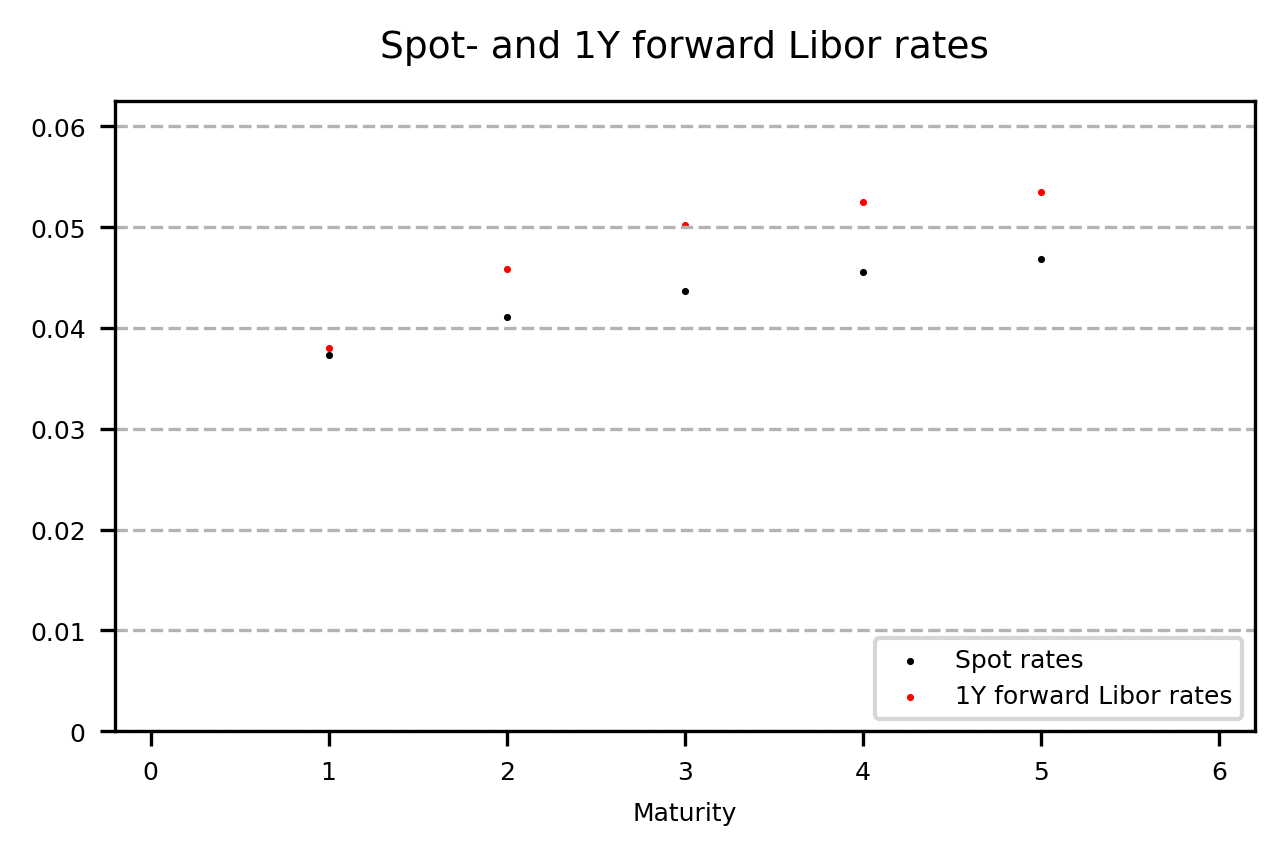

In [2]:
M = 6
alpha = 1
strike = 0.045
R = np.array([np.nan,0.03731561,0.04106146,0.04370112,0.04556125,0.04687207])
sigma_market_1b = np.array([0,0,0.041,0.052,0.065,0.083])
sigma_market_1d = np.array([0,0,0.045,0.057,0.073,0.096])

# Problem 1
strike = 0.045
T = np.array([m*alpha for m in range(0,M)])
p = np.ones(M)
L, price_caplet_1, alpha = np.zeros([M]), np.zeros(M), np.zeros(M)
sigma_lmm = np.ones(M)
for i in range(1,M):
    p[i] = np.exp(-R[i]*T[i])
    alpha[i] = T[i]-T[i-1] # alpha does not have to be 1 as in this case, time intervals could be different
    L[i] = (1/alpha[i])*(p[i-1] - p[i])/p[i]
    if i > 1:
        price_caplet_1[i] = fid.black_caplet_price(sigma_market_1b[i],T[i],strike,alpha[i],p[i],L[i],type = 'call')
print(f"caplet prices: {price_caplet_1*10000}")
price_cap_1b = sum(price_caplet_1)
print(f"cap price: {price_cap_1b*10000}.") # in basis points of the notional
R_swap_1b, S_swap_1b = fid.swap_rate_from_zcb_prices(0,0,5,"annual",T,p)
print(f"R_swap_1b: {R_swap_1b}, S_swap_1b: {S_swap_1b}")
premium_1b = price_cap_1b/S_swap_1b
print(f"cap annual premium_1b: {premium_1b*10000}")
price_cap_1c = sum(price_caplet_1[3:])
print(f"cap price: {price_cap_1c*10000}.")
R_swap_1c, S_swap_1c = fid.swap_rate_from_zcb_prices(0,2,5,"annual",T,p)
print(f"R_swap_1c: {R_swap_1c}, S_swap_1c: {S_swap_1c}")
premium_1c = price_cap_1c/S_swap_1c
print(f"cap annual premium: {premium_1c*10000}")

fig = plt.figure(constrained_layout=False, dpi = 300, figsize = (5,3))
fig.suptitle(f"Spot- and 1Y forward Libor rates", fontsize = 9)
gs = fig.add_gridspec(nrows=1,ncols=1,left=0.12,bottom=0.2,right=0.88,top=0.90,wspace=0,hspace=0)
ax = fig.add_subplot(gs[0,0])
xticks = [0,1,2,3,4,5,6]
ax.set_xticks(xticks)
ax.set_xticklabels(xticks,fontsize = 6)
ax.set_xlim([xticks[0]+-0.2,xticks[-1]+0.2])
plt.xlabel(f"Maturity",fontsize = 6)
ax.set_yticks([0,0.01,0.02,0.03,0.04,0.05,0.06])
ax.set_yticklabels([0,0.01,0.02,0.03,0.04,0.05,0.06],fontsize = 6)
ax.set_ylim([0,0.0625])
plt.grid(axis = 'y', which='major', color=(0.7,0.7,0.7,0), linestyle='--')
p1 = ax.scatter(T[1:], R[1:], s = 2, color = 'black', marker = ".",label="Spot rates")
p2 = ax.scatter(T[1:], L[1:], s = 2, color = 'red', marker = ".",label="1Y forward Libor rates")
plots = [p1,p2]
labels = [item.get_label() for item in plots]
ax.legend(plots,labels,loc="lower right",fontsize = 6)
plt.show()


### 1d


In [3]:
# Problem 1d
strike = 0.05
price_caplet_1d = np.zeros(M)
for i in range(2,M):
    price_caplet_1d[i] = fid.black_caplet_price(sigma_market_1d[i],T[i],strike,alpha[i],p[i],L[i],type = 'call')
print(f"caplet prices: {price_caplet_1d*10000}")
price_cap_1d = sum(price_caplet_1d)
print(f"cap price: {price_cap_1d*10000}.")
R_swap_1d, S_swap_1d = fid.swap_rate_from_zcb_prices(0,0,5,"annual",T,p)
print(f"R_swap_1d: {R_swap_1d}, S_swap_1d: {S_swap_1d}")
premium_1d = price_cap_1d/S_swap_1d
print(f"cap annual premium_1d: {premium_1d*10000}")



caplet prices: [ 0.          0.          1.09928057 18.1912882  36.49168066 50.53728911]
cap price: 106.31953854258.
R_swap_1d: 0.04763270099674098, S_swap_1d: 4.3861317034117775
cap annual premium_1d: 24.239932982376875


## Problem 2

\begin{align*}
\bar{\sigma}_i^2 = \frac{1}{T_i}\int_0^{T_{i-1}} = \sigma_i^2(t)dt \\
\sigma_i = \text{constant} \\
\bar{\sigma}_i^2 = \frac{T_{i-1}}{T_i} \sigma_i^2  \\
\sigma_i^2 = \frac{T_i}{T_{i-1}} \bar{\sigma}_i^2
\end{align*}

## Problem 3

Time of fixing at $T_0$, $T_1$, $T_2$, $T_3$, $T_4$.

Libor cahsflows at $T_1$, $T_2$, $T_3$, $T_4$, $T_5$.

Model: $L_2(t)$, $L_3(t)$, $L_4(t)$, and $L_5(t)$

$L_2(t)$ is "wiggeling" until $T_1$ where it is fixed to be paid at $T_2$. The same goes for $L_3(t)$, $L_4(t)$, and $L_5(t)$, being fixed at $T_2$, $T_3$, and $T_4$ respectively as seen in the figure below.

We have a system of libor rates
$$
\bar{L}(t) = \begin{bmatrix} L_2(t) \\ L_3(t) \\ L_4(t) \\ L_5(t) \end{bmatrix} \\
d\bar{L}(t) = \begin{bmatrix} \sigma_2 & 0 & 0 & 0 \\ 0 & \sigma_3 & 0 & 0 \\ 0 & 0 & \sigma_4 & 0 \\ 0 & 0 & 0 & \sigma_5 \end{bmatrix} \underset{4 \times 4}{A}\begin{bmatrix} dW_1(t) \\ dW_2(t) \\ dW_3(t) \\ dW_4(t) \end{bmatrix}
$$
$$
A_{i\cdot} A_{\cdot i} = 1 \quad \text{where } \cdot \in \text{ are elements in the matrix}
$$
$$
AA' = \Omega = \begin{bmatrix} 1 & \cdots \\ \rho_{21} &  \cdots \\ \rho_{31} & \cdots \end{bmatrix}
$$
Then difufusion coefficient (scalar) will be $\sigma_i$(t) and $Corr[L_i(t), L_k(t)] = \rho_{ik}$

If $W(t)$ is a K-dimensional vector of independent Brownian motion, then the what is Covariance matrix og $\underset{K \times K}{A}\underset{K \times 1}{W(t)}$?

The covariance materix would be 
$$
A \cdot \begin{bmatrix} t & 0 & 0 & 0 \\ 0 & t & 0 & 0 \\ 0 & 0 & t & 0 \\ 0 & 0 & 0 & t \end{bmatrix} \cdot A'
$$
The cpalet $Capl_i(t)$ is in th LMM a $\mathbb{Q}^N$ martingale and is given by
$$
\frac{Capl_i(t)}{p(t,T_i)} = \overset{\mathbb{Q}^N}{\mathbb{E}}\left[\frac{Capl_i(T_N)}{p(T_N,T_i)}\right], \quad \text{where } N = 5 \text{ (for our case)} \\
= \overset{\mathbb{Q}^N}{\mathbb{E}}[Capl_i(T_N)]
$$
Remeber if $i=3$ and $N=5$ then we can discount the cashflow forwards to $T_5$ using the subsequent LIBOR rates
$$ 
1+\alpha L(t,T) = \frac{1}{p(t,T)} \\
p(0,T) = p(0,s)p(0,s,T)
$$

Here we are using the higher sigmas (form 5%) to simulate which is a more conservative approach and will give higher prices for the caplet compared to the lower sigmas (from 4%). 


caplet_price for a strike of 0.0475 is [ 0.         28.62668247 53.5448206  66.45288979], cap price: 148.6243928654764


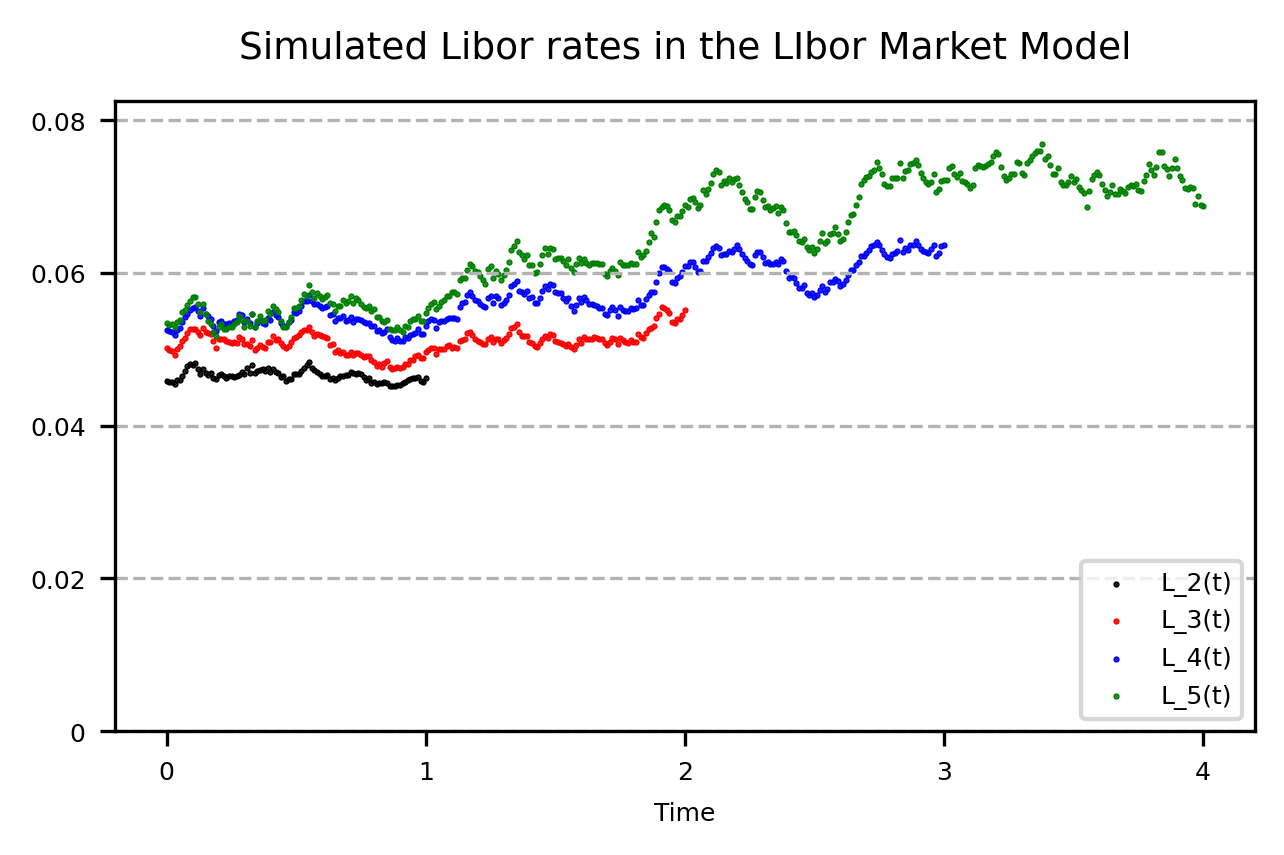

In [ ]:
# Problem 3 - Simulation of the Libor market model
np.random.seed(2024) # seed not used by JLS but used by me for reproducibility
M_simul, T_simul = 400, 4
sigma_lmm = np.zeros([M-2])
for i in range(0,M-2):
    sigma_lmm[i] = sigma_market_1b[i+2]*np.sqrt(T[i+2]/T[i+1])
rho = np.array([[1,0.5,0.9,0.85],[0.95,1,0.95,0.9],[0.9,0.95,1,0.95],[0.85,0.9,0.95,1]])
rho_sqrt = sqrtm(rho)
L_simul = fid.simul_lmm(L[2:M],T[1:M],sigma_lmm,rho,M_simul)
t_simul = np.array([i*T_simul/M_simul for i in range(0,M_simul+1)])

strike_lmm = 0.0475
N_simul = 1000
caplet_price_3, L_exercise = np.zeros(M-2), np.zeros(M-2)
chi_disc = np.zeros([M-2,N_simul])
for n in range(0,N_simul):
    L_simul = fid.simul_lmm(L[2:M],T[1:M],sigma_lmm,rho,M_simul)
    for j in range(0,M-2):
        L_exercise[j] = L_simul[j,int(j*M_simul/4)+1]
        chi_disc[j,n] = p[-1]*alpha[j+2]*max(L_exercise[j] - strike_lmm,0)
        for k in range(j,M-2):
            chi_disc[j,n] *= (1+alpha[k+2]*L_exercise[k])
for i in range(0,M-2):
    caplet_price_3[i] = sum(chi_disc[i,:])/N_simul*10000
print(f"caplet_price for a strike of {strike_lmm} is {caplet_price_3}, cap price: {sum(caplet_price_3)}")


fig = plt.figure(constrained_layout=False, dpi = 300, figsize = (5,3))
fig.suptitle(f"Simulated Libor rates in the LIbor Market Model", fontsize = 9)
gs = fig.add_gridspec(nrows=1,ncols=1,left=0.12,bottom=0.2,right=0.88,top=0.90,wspace=0,hspace=0)
ax = fig.add_subplot(gs[0,0])
xticks = np.array([0,1,2,3,4])
ax.set_xticks(xticks)
ax.set_xticklabels(xticks,fontsize = 6)
ax.set_xlim([xticks[0]+-0.2,xticks[-1]+0.2])
# ax.set_xlim([xticks[0]+-0.2,2+0.2])
plt.xlabel(f"Time",fontsize = 6)
ax.set_yticks([0,0.02,0.04,0.06,0.08])
ax.set_yticklabels([0,0.02,0.04,0.06,0.08],fontsize = 6)
ax.set_ylim([0,0.0825])
plt.grid(axis = 'y', which='major', color=(0.7,0.7,0.7,0), linestyle='--')
p1 = ax.scatter(t_simul, L_simul[0,:], s = 1, color = 'black', marker = ".",label="L_2(t)")
p2 = ax.scatter(t_simul, L_simul[1,:], s = 1, color = 'red', marker = ".",label="L_3(t)")
p3 = ax.scatter(t_simul, L_simul[2,:], s = 1, color = 'blue', marker = ".",label="L_4(t)")
p4 = ax.scatter(t_simul, L_simul[3,:], s = 1, color = 'green', marker = ".",label="L_5(t)")
plots = [p1,p2,p3,p4]
labels = [item.get_label() for item in plots]
ax.legend(plots,labels,loc="lower right",fontsize = 6)
plt.show()

